<a href="https://colab.research.google.com/github/DataRecouver/Codes-DataScience-Python/blob/main/Hands%20On/03_BBC_news_(pr%C3%A1tica_classifica%C3%A7%C3%A3o_de_textos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBC News Raw Dataset

Análise sobre o conjunto de dados BBC News Raw Dataset

Fontes:

* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
* https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
* https://machinelearningmastery.com/clean-text-machine-learning-python/
* https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8



#ATENÇÃO: ISSO NÃO É UMA RECEITA DE BOLO

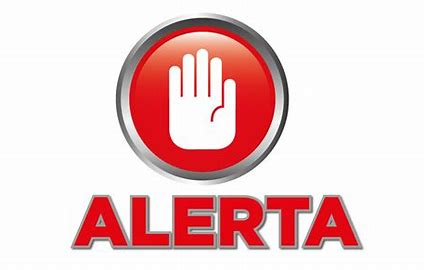

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
sns.set_style("whitegrid")
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('News_dataset.csv')

In [3]:
df


,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business
...,...,...,...,...
2220,397.txt,BT program to beat dialler scams\n\nBT is intr...,tech,397.txt-tech
2221,398.txt,Spam e-mails tempt net shoppers\n\nComputer us...,tech,398.txt-tech
2222,399.txt,Be careful how you code\n\nA new European dire...,tech,399.txt-tech
2223,400.txt,US cyber security chief resigns\n\nThe man mak...,tech,400.txt-tech


# Análise exploratória dos dados

In [4]:
df.head()

,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business


## Número de artigos por classe

In [5]:
df.Category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

In [6]:
df2 = pd.DataFrame(df.groupby('Category').count()['Content']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(Content)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.Content / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

## Análise sobre o tamanho dos artigos

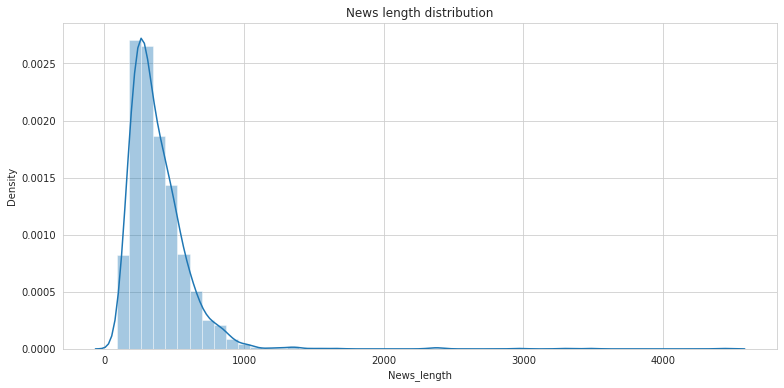

In [7]:
df['News_length'] =  [len(sentence.split()) for sentence in df['Content']]
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution');

In [8]:
df['News_length'].describe()

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: News_length, dtype: float64

**Cortando a calda para analizar melhor o histograma**


In [9]:
#número de artigos com mais de 1000 palavras
df[df['News_length'] > 1000].shape[0]

24

Text(0.5, 1.0, 'News length distribution')

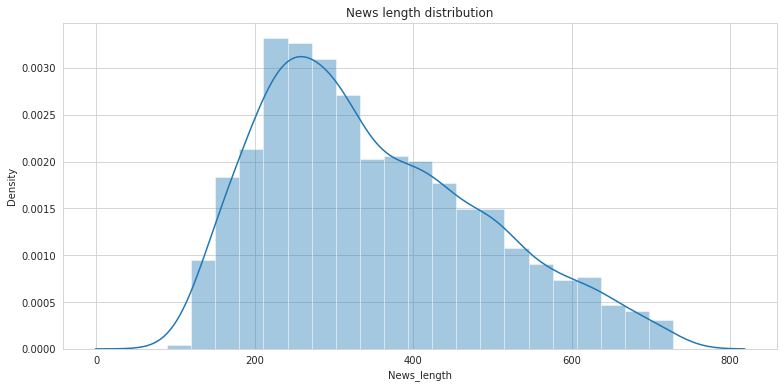

In [10]:
quantile_95 = df['News_length'].quantile(0.95)
df_95 = df[df['News_length'] < quantile_95]
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length'], norm_hist = True).set_title('News length distribution')

**Distribuição do tamanho dos artigos por classe**

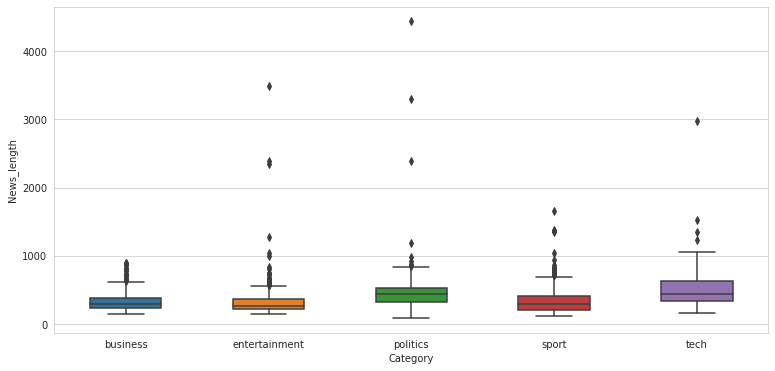

In [11]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5);

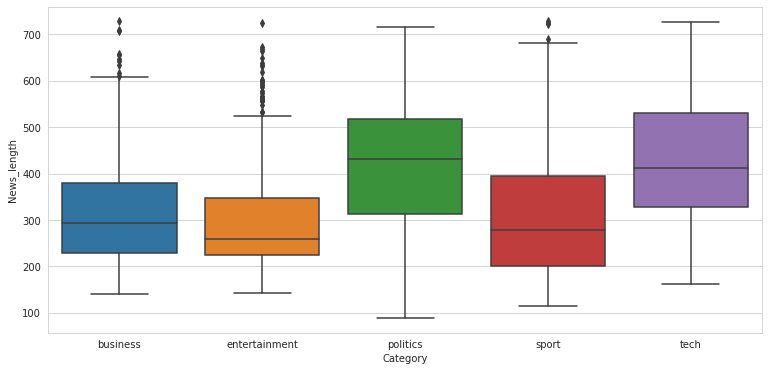

In [12]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

# Engenharia de atributos

In [13]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string

In [14]:
df.loc[1]['Content']

'Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions u

## 1. Limpeza dos dados

**1.1. Limpeza de caracteres especiais:**

  * \r
  * \n
  * pronomes pocessivos \'s (government's = government\'s)
  * sinais de pontuação





In [15]:
# \'s  \r  \n 
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\'s", "")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")


In [16]:
#Exemplo de remoção de sinais de pontuação e caracteres especiais

input_str = 'This & is [an] example? {of} string. with.? punctuation!!!!' 
punctuation = re.compile(r'[^A-Za-z0-9]+')
punctuation.sub(" ", input_str)


'This is an example of string with punctuation '

In [17]:
#Remoção de caracteres especiais e números

input_str = 'This &is [an] example? {of} string. with.? punctuation!!!! 99' 

result = input_str.translate(str.maketrans('','', string.punctuation))
print(result)

result = result.translate(str.maketrans('','', string.digits))
print(result)

This is an example of string with punctuation 99
This is an example of string with punctuation 


In [18]:
#Aplicando na base

df['Content_Parsed_1'] = [content.translate(str.maketrans('','', string.punctuation)) for content in df['Content_Parsed_1']]
df['Content_Parsed_1'] = [content.translate(str.maketrans('','', string.digits)) for content in df['Content_Parsed_1']]

In [19]:

print('Antes: \n'+ df.loc[0]['Content'] + '\n \n')

print('Depois: \n'+ df.loc[0]['Content_Parsed_1'])


Antes: 
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

**1.2. Conversão para letras minúsculas**

In [20]:
# convertendo para minúsculo
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

**1.3. Remoção de stopwords**

In [21]:
# baixando as listas de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# carregando a lista de stopwords em inglês
stop_words = list(stopwords.words('english'))
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
#Exemplo de remoção de stopwords 
example = "me eating a meal"
word = "me"

regex = r"\b" + word + r"\b" 

re.sub(regex, "", example)

' eating a meal'

In [24]:
#Aplicando na base

df['Content_Parsed_3'] = df['Content_Parsed_2']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(regex_stopword, '')

**1.4. Stemming ou  lematização**

***Stemming:*** Stemming é o processo de reduzir a inflexão em palavras às suas formas-raiz, como mapear um grupo de palavras para o mesmo radical, mesmo que o radical em si não seja uma palavra válida na linguagem

***Lematização:*** A lematização, ao contrário do Stemming, reduz as palavras flexionadas garantindo adequadamente que a palavra raiz pertence à linguagem. Na lematização, a palavra raiz é chamada de Lema. Um lema (plural lemmas ou lemmata) é a forma canônica, a forma de dicionário ou a forma de citação de um conjunto de palavras.

In [25]:
#nltk.download('punkt')
#print("------------------------------------------------------------")
#nltk.download('wordnet')
#print("------------------------------------------------------------")
#nltk.download('averaged_perceptron_tagger')

In [26]:
#!pip install nltk

In [27]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

wnl = WordNetLemmatizer()
porter = PorterStemmer()
lancaster=LancasterStemmer()
snowball = SnowballStemmer(language="english")
#ptstemmer = SnowballStemmer(language="portuguese")

word_list = ["friends", "amity", "studies", "studing", "destabilization","aardwolves","wedding"]
print("{0:20}{1:20}{2:20}{3:20}{4:20}{5:20}".format("Palavra","Porter Stemmer", "SnowballStemmer", "lancaster Stemmer","Wordnet_Substantivo","Wordnet_Verbo"))
print("")
for word in word_list:
    print("{0:20}{1:20}{2:20}{3:20}{4:20}{5:20}".format(word,porter.stem(word), snowball.stem(word), lancaster.stem(word), wnl.lemmatize(word,pos=wordnet.NOUN),wnl.lemmatize(word,pos=wordnet.VERB)))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Palavra             Porter Stemmer      SnowballStemmer     lancaster Stemmer   Wordnet_Substantivo Wordnet_Verbo       

friends             friend              friend              friend              friend              friends             
amity               amiti               amiti               am                  amity               amity               
studies             studi               studi               study               study               study               
studing             stude               stude               stud                studing             stud                
destabilization     destabil            destabil            dest                destabilization     destabilization     
aardwolves          aardwolv            aardwolv            aardwolv            aardwolf            aardwolves          
wedding             wed                 wed                 wed                 wedding             wed                 


In [29]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [30]:
wordnet_lemmatizer = WordNetLemmatizer()

nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    
    # Salvando o texto e suas palavras em um objeto
    text = df.loc[row]['Content_Parsed_3']
    lemmatized_list = [wordnet_lemmatizer.lemmatize(w, pos = get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
        
    # transformando o vetor de palavras lematizadas em um texto novamente
    lemmatized_text = " ".join(lemmatized_list)
    
    # adicionando o novo texto na lista de textos transformados
    lemmatized_text_list.append(lemmatized_text)
    
df['Content_Parsed_4'] = lemmatized_text_list

In [31]:
#stemming
lancaster = LancasterStemmer()

nrows = len(df)
stemmed_text_list = []

for row in range(0, nrows):
    
    stemmed_list = []
    
    # Salvando o texto e suas palavras em um objeto
    text = df.loc[row]['Content_Parsed_3']
    stemmed_list = [lancaster.stem(w) for w in nltk.word_tokenize(text)]
        
    # transformando o vetor de palavras transformadas em um texto novamente
    stemmed_list = " ".join(stemmed_list)
    
    # adicionando o novo texto na lista de textos transformados
    stemmed_text_list.append(stemmed_list)
    
df['Content_Parsed_4_b'] = stemmed_text_list

In [32]:
df.loc[5]['Content']

'Japan narrowly escapes recession\n\nJapan\'s economy teetered on the brink of a technical recession in the three months to September, figures show.\n\nRevised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.\n\nThe government was keen to play down the worrying implications of the data. "I maintain the view that Japan\'s economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It\'s painting a picture of a recovery... much patchier than previously thought," said Pa

In [33]:
df.loc[5]['Content_Parsed_1']

'Japan narrowly escapes recession  Japan economy teetered on the brink of a technical recession in the three months to September figures show  Revised figures indicated growth of just   and a similarsized contraction in the previous quarter On an annual basis the data suggests annual growth of just  suggesting a much more hesitant recovery than had previously been thought A common technical definition of a recession is two successive quarters of negative growth  The government was keen to play down the worrying implications of the data I maintain the view that Japan economy remains in a minor adjustment phase in an upward climb and we will monitor developments carefully said economy minister Heizo Takenaka But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead observers were less sanguine It painting a picture of a recovery much patchier than previously thought said Paul Sheard economist at Lehman Brothers in Toky

In [34]:
df.loc[5]['Content_Parsed_2']

'japan narrowly escapes recession  japan economy teetered on the brink of a technical recession in the three months to september figures show  revised figures indicated growth of just   and a similarsized contraction in the previous quarter on an annual basis the data suggests annual growth of just  suggesting a much more hesitant recovery than had previously been thought a common technical definition of a recession is two successive quarters of negative growth  the government was keen to play down the worrying implications of the data i maintain the view that japan economy remains in a minor adjustment phase in an upward climb and we will monitor developments carefully said economy minister heizo takenaka but in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead observers were less sanguine it painting a picture of a recovery much patchier than previously thought said paul sheard economist at lehman brothers in toky

In [35]:
df.loc[5]['Content_Parsed_3']

'japan narrowly escapes recession  japan economy teetered   brink   technical recession   three months  september figures show  revised figures indicated growth       similarsized contraction   previous quarter   annual basis  data suggests annual growth    suggesting  much  hesitant recovery   previously  thought  common technical definition   recession  two successive quarters  negative growth   government  keen  play   worrying implications   data  maintain  view  japan economy remains   minor adjustment phase   upward climb    monitor developments carefully said economy minister heizo takenaka    face   strengthening yen making exports less competitive  indications  weakening economic conditions ahead observers  less sanguine  painting  picture   recovery much patchier  previously thought said paul sheard economist  lehman brothers  tokyo improvements   job market apparently  yet  feed   domestic demand  private consumption      third quarter'

In [36]:
df.loc[5]['Content_Parsed_4']

'japan narrowly escape recession japan economy teeter brink technical recession three month september figure show revise figure indicate growth similarsized contraction previous quarter annual basis data suggests annual growth suggest much hesitant recovery previously thought common technical definition recession two successive quarter negative growth government keen play worry implication data maintain view japan economy remains minor adjustment phase upward climb monitor development carefully say economy minister heizo takenaka face strengthen yen make export less competitive indication weaken economic condition ahead observer less sanguine painting picture recovery much patchier previously thought say paul sheard economist lehman brother tokyo improvement job market apparently yet feed domestic demand private consumption third quarter'

In [37]:
df.loc[5]['Content_Parsed_4_b']

'jap narrow escap recess jap econom teet brink techn recess three month septemb fig show rev fig ind grow similars contract prevy quart an bas dat suggest an grow suggest much hesit recovery prevy thought common techn definit recess two success quart neg grow govern keen play worry imply dat maintain view jap econom remain min adjust phas upward climb monit develop car said econom min heizo takenak fac strengthening yen mak export less competit ind weak econom condit ahead observ less sanguin paint pict recovery much patchy prevy thought said paul sheard econom lehm broth tokyo improv job market app yet fee domest demand priv consum third quart'

In [38]:
#Base tratada
df['Content_Parsed'] = df['Content_Parsed_4']

## 2. Codificação dos rótulos

In [39]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

In [40]:
# Mapeamento das categorias
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

In [41]:
df.head()

,File_Name,Content,Category,Complete_Filename,News_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_4_b,Content_Parsed,Category_Code
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business,421,Ad sales boost Time Warner profit Quarterly p...,ad sales boost time warner profit quarterly p...,ad sales boost time warner profit quarterly p...,ad sale boost time warner profit quarterly pro...,ad sal boost tim warn profit quart profit us m...,ad sale boost time warner profit quarterly pro...,0
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business,384,Dollar gains on Greenspan speech The dollar h...,dollar gains on greenspan speech the dollar h...,dollar gains greenspan speech dollar hit ...,dollar gain greenspan speech dollar hit high l...,doll gain greensp speech doll hit highest leve...,dollar gain greenspan speech dollar hit high l...,0
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business,264,Yukos unit buyer faces loan claim The owners ...,yukos unit buyer faces loan claim the owners ...,yukos unit buyer faces loan claim owners em...,yukos unit buyer face loan claim owner embattl...,yuko unit buy fac loan claim own embattl russ ...,yukos unit buyer face loan claim owner embattl...,0
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business,406,High fuel prices hit BA profits British Airwa...,high fuel prices hit ba profits british airwa...,high fuel prices hit ba profits british airwa...,high fuel price hit ba profit british airway b...,high fuel pric hit ba profit brit airway blam ...,high fuel price hit ba profit british airway b...,0
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business,265,Pernod takeover talk lifts Domecq Shares in U...,pernod takeover talk lifts domecq shares in u...,pernod takeover talk lifts domecq shares uk ...,pernod takeover talk lift domecq share uk drin...,pernod takeov talk lift domecq shar uk drink f...,pernod takeover talk lift domecq share uk drin...,0


## 3.  Divisão de conjuntos de treinamento e teste

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=1)

## 4. Transformação dos dados (representação de textos)


Alguns tipos

*   ***Count Vectors*** 
*   ***Boolean Vectors***
*   ***TF-IDF Vectors***
*   ***Word Embeddings***
*   ***Text / NLP based features***



### TF-IDF

O TF-IDF é uma pontuação que representa a importância relativa de um termo no documento e em todo o corpus. TF significa Term Frequency e IDF significa Frequência Inversa do Documento:

![alt text](https://cdn-images-1.medium.com/max/1000/0*oamFbfNAyVptRlLz.png)

O valor TF-IDF aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento e é compensada pelo número de documentos no corpus que contém a palavra, o que ajuda a ajustar o fato de que algumas palavras aparecem com mais frequência em geral.

Também leva em conta o fato de que alguns documentos podem ser maiores do que outros ao normalizar o termo do TF (expressando, ao invés disso, frequências relativas de termos).

Esses dois métodos (Vetores de Contagem de Palavras e Vetores TF-IDF) são freqüentemente chamados de métodos de Bag of Words, uma vez que a ordem das palavras em uma sentença é ignorada.

**Parâmetros importantes**

* ngram_range: se queremos utilizar tokens simples ou compostos;
* max_df: número máximo de documentos que um token precisa ocorrer para ser considerado;
* min_df: número mínimo de documentos que um token precisa ocorrer para ser considerado;
* max_features: se diferente de None, cria um vocabulário de tamanho max_features com apenas com os tokens que ocorrem mais na base.
* strip_accents: remove acentos;
* stopwords: recebe a lista de stopwords para serem removidas (mais rápido que o método anteriormente apresentado).


Outros parâmetros: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [43]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = None

In [44]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1891, 5463)
(334, 5463)


Podemos agora utilizar o teste chi2 para identificar as palavras mais correlacionadas com cada classe.

In [45]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'business' category:
  . Most correlated unigrams:
. economy
. oil
. bank
. growth
. bn
  . Most correlated bigrams:
. analyst say
. bn bn

# 'entertainment' category:
  . Most correlated unigrams:
. actor
. singer
. star
. award
. film
  . Most correlated bigrams:
. film festival
. box office

# 'politics' category:
  . Most correlated unigrams:
. blair
. party
. election
. labour
. tory
  . Most correlated bigrams:
. tony blair
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. injury
. champion
. coach
. cup
. match
  . Most correlated bigrams:
. grand slam
. six nation

# 'tech' category:
  . Most correlated unigrams:
. mobile
. computer
. software
. technology
. user
  . Most correlated bigrams:
. let people
. mobile phone



## 5. Seleção de Atributos

In [46]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=300)
features_train = selector.fit_transform(features_train, labels_train)
features_test = selector.transform(features_test)

print(features_train.shape)
print(features_test.shape)


(1891, 300)
(334, 300)


In [47]:
features_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05525641,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Criação do Modelo


In [48]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer

score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}

df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores


## 1. Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

### 1.1. Ajuste de Parâmetros



In [50]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
print(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


**Randomized Search Cross Validation**

In [51]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [52]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=5, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'},
                   verbose=1)

In [53]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Radom Search são:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}

A macro F1 obtida com esses hiperparâmetros é:
0.9613523186994125


In [54]:
random_search.cv_results_

{'mean_fit_time': array([3.73705546, 2.77208813, 6.19154803, 2.6502947 , 3.22542787]),
 'std_fit_time': array([0.64426165, 0.0592446 , 0.98984907, 0.02852332, 0.44054675]),
 'mean_score_time': array([0.16763703, 0.1637946 , 0.31777819, 0.14882421, 0.1955595 ]),
 'std_score_time': array([0.00610569, 0.01811206, 0.0397255 , 0.00096132, 0.07611066]),
 'param_n_estimators': masked_array(data=[400, 400, 800, 400, 400],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 2, 10, 10, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 1, 4, 4, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'auto', 'auto', 'sqrt', 'sqrt'],
              mask=[False, False, False, False, 

**Grid Search Cross Validation**

In [ ]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1, n_jobs =2)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [ ]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(grid_search.best_params_)
print("")
print("A acurácia média obtida com esses hiperparâmetros é:")
print(grid_search.best_score_)

In [ ]:
results = random_search.cv_results_

In [ ]:
best_rfc = random_search.best_estimator_ 
best_rfc

### 1.2. Treinamento e avaliação do modelo



In [ ]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

In [ ]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

In [ ]:
acc = accuracy_score(labels_test, rfc_pred)
f1 = f1_score(labels_test, rfc_pred, average='macro')
print(classification_report(labels_test,rfc_pred))

aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

In [ ]:
d = {
     'Estimator': 'Random Forest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [ ]:
df_estimators_scores

## 2. Support Vector Machine


![](https://www.researchgate.net/profile/Elisa_Aleman_Carreon/publication/323137738/figure/fig2/AS:735529951842304@1552375414012/2D-example-of-the-Linear-SVM-classification-The-linear-kernel-for-the-SVM-classification.png)



In [ ]:
from sklearn import svm

### 2.1. Ajuste de Parâmetros

In [ ]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Vamos ajustar os seguintes parâmetros:

* C: Tolerância a erros de classificação;
* kernel: Especifica o Kernel;
* gamma: coeficiente do kernel (aplicável para os kernels ‘rbf’, ‘poly’ e ‘sigmoid’);
* degree: quando o kernel for polinomial, determina o grau.

**Parâmetro Kernel**

Define uma função de transformação dos dados de modo a representá-los em um conjunto de dimensões diferente do original a fim de melhor separá-los

![alt text](https://blog-c7ff.kxcdn.com/blog/wp-content/uploads/2017/02/kernel.png)

**Parâmetro C**

Tolerância a erros de classificação em prol da maximização da margem de decisão

![alt text](https://i.stack.imgur.com/GbW5S.png)

**Parâmetro gamma**

Gama define o alcance da influência de um único exemplo de treinamento na definição dos limites de decisão. 

Um gama baixo levará em consideração exemplos de treinamento que estão mais longe do limite de decisão e um gama alto considerará os pontos mais próximos do limite de decisão.

Gama alto =  overfitting
Gama baixo = underfitting

gamma = 0.001

![alt text](http://wiki.eigenvector.com/images/thumb/7/73/C1g0p001.png/400px-C1g0p001.png)

gamma = 0.01

![alt text](http://wiki.eigenvector.com/images/thumb/f/f6/C1g0p01.png/400px-C1g0p01.png)

gamma = 0.1

![alt text](http://wiki.eigenvector.com/images/thumb/1/1b/C1g10.png/400px-C1g10.png)

Mais variações: http://wiki.eigenvector.com/index.php?title=Svmda

**Parâmetro degree**

Quanto maior o grau da função polinomial, maior a flexibilidade do limite de decisão.

![alt text](https://www.researchgate.net/profile/Cheng_Soon_Ong/publication/23442384/figure/fig12/AS:341444054274063@1458418014823/The-effect-of-the-degree-of-a-polynomial-kernel-The-polynomial-kernel-of-degree-1-leads.png)



In [ ]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

**Randomized Search Cross Validation**

In [ ]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=5,
                                   scoring=score_metrics,
                                   refit='F1',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs =2)

# Fit the random search model
random_search.fit(features_train, labels_train)

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Radom Search são:")
print(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

In [ ]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_svm

In [ ]:
results

### 2.2. Treinamento e avaliação do modelo

In [ ]:
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
best_scorer_index

In [ ]:
best_svm.fit(features_train, labels_train)
svm_pred = best_svm.predict(features_test)


In [ ]:
acc = accuracy_score(labels_test, svm_pred)
f1 = f1_score(labels_test, svm_pred, average='macro')
print(classification_report(labels_test,svm_pred))

In [ ]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, svm_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
labels_test.value_counts()

In [ ]:
aux_df['Category']

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

In [ ]:
['Estimator', 'Cross-validation Scores', 'Test Set Scores']

d = {
     'Estimator': 'SVM',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

df_estimators_scores

In [ ]:
df_estimators_scores

## 3. Multinomial Naïve Bayes

Digamos que estamos trabalhando no diagnóstico de uma nova doença, e que fizemos testes em 100 pessoas distintas.

Após coletarmos a análise, descobriu-se que:

* 100 pessoas realizaram o teste.
* 20% das pessoas que realizaram o teste possuíam a doença.
* 90% das pessoas que possuíam a doença, receberam positivo no teste.
* 30% das pessoas que não possuíam a doença, receberam positivo no teste.

Se uma nova pessoa realizar o teste e receber um resultado positivo, qual a probabilidade de ela possuir a doença?

![alt text](https://annalloyd.files.wordpress.com/2019/03/bayes-1.png?w=635&h=391)

**Solução:**

* P(doença|positivo) = 0,2 * 0,9
* P(doença|positivo) = 0,18

* P(não doença|positivo) = 0,8 * 0,3
* P(não doença|positivo) = 0,24

Após isso precisamos normalizar os dados, para que a soma das duas probabilidades resulte 1 (100%).

Para isso, dividimos o resultado pela soma das duas probabilidades.


P(doença|positivo) = 0,18/(0,18+0,24) = 0,4285

P(não doença|positivo) = 0,24/(0,18+0,24) = 0,5714


Assim sendo, se uma pessoa realizar o teste e receber um resultado positivo, a probabilidade de ela possuir a doença é de 57,14%


**Tipos de Naive bayes no sklearn**

* Bernoulli:  para atributos binários;
* Multinomial: atributos categóricos ou de contagem (funciona bem para contagens fracionárias como o TF-IDF);
* Gaussian: ideal para quando todos os atributos são contínuos, porém assume que a distribuição desses atributos é normal.

Fonte: https://www.organicadigital.com/seeds/algoritmo-de-classificacao-naive-bayes/


### E para texto??

P(I have huge respect for women) = P(I) × P(have) × P(huge) × P(respect) × P(for) × P(women)

P(I have huge respect for women|Trump) = P(I|Trump) × P(have|Trump) × P(huge|Trump) × P(respect|Trump) × P(for|Trump) × P(women|Trump)

P(I have huge respect for women|NotTrump) = P(I|NotTrump) × P(have|NotTrump) × P(huge|NotTrump) × P(respect|NotTrump) × P(for|NotTrump) × P(women|NotTrump)

**E se P(I) = 0?**

Parâmetro alpha 

In [ ]:
from sklearn.naive_bayes import MultinomialNB 

### 3.1. Ajuste de Parâmetros


In [ ]:
mnbc = MultinomialNB()
mnbc

Aqui vamos utilizar o valor padrão de Alpha (indicando que deseja-se utilizar a suavização de Laplace)

### 3.2. Treinamento e avaliação do modelo

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
scores = cross_validate(mnbc, features_train, labels_train, scoring=score_metrics, cv=3, return_train_score=True)

In [ ]:
print(scores.keys())
print(scores['test_F1'])  

In [ ]:
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

acc = accuracy_score(labels_test, mnbc_pred)
f1 = f1_score(labels_test, mnbc_pred, average='macro')
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

In [ ]:
d = {
     'Estimator': 'MultinomialNB',
     'Cross-validation Scores': (round(np.mean(scores['test_F1']),3), round(np.mean(scores['test_Accuracy']),3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)


In [ ]:
df_estimators_scores

# Análise do modelo


Vamos escolher o modelo gerado com o algoritmo Naive Bayes por ter alcançado os melhores indicadores.

Apesar de a acurácia e a medida f1 terem alcançado valores próximos de 1, ainda existem erros de classificação. Vamos agora analisar esses erros para entender esse comportamento.

In [ ]:
predictions = mnbc.predict(features_test)

Vamos criar o dataframe do conjunto de testes com as categorias reais e previstas:

In [ ]:
# Category mapping dictionary
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

category_names = {
    0: 'business',
    1: 'entertainment',
    2: 'politics',
    3: 'sport',
    4: 'tech'
}

# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = predictions

# Clean columns
df_test = df_test[['Content', 'Category', 'Category_Code', 'Prediction']]

# Decode
df_test['Category_Predicted'] = df_test['Prediction']
df_test = df_test.replace({'Category_Predicted':category_names})

# Clean columns again
df_test = df_test[['Content', 'Category', 'Category_Predicted']]

In [ ]:
df_test.head()

Vamos pegar os artigos classificados incorretamente:

In [ ]:
condition = (df_test['Category'] != df_test['Category_Predicted'])

df_misclassified = df_test[condition]

df_misclassified.head(5)

Vamos pegar uma amostra de 3 artigos. Vamos definir uma função para tornar esse processo mais rápido:

In [ ]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['Category']))
    print('Predicted Category: %s' %(row_article['Category_Predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['Content']))

Selecionar três índices aleatoriamente:

In [ ]:
import random

random.seed(1)
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

**Texto 1**

In [ ]:
output_article(df_misclassified.loc[list_samples[0]])

**Texto 2**

In [ ]:
output_article(df_misclassified.loc[list_samples[1]])

**Texto 3**

In [ ]:
output_article(df_misclassified.loc[list_samples[2]])